In [1]:
import os
import sys

sys.path.append(os.getcwd() + '/')

In [2]:
from experiments import setup_experiments

exps = setup_experiments("far_bias")

In [3]:
exps.path

'/data/Data/SimBA-MACAW/far_bias'

In [4]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

no_bias_dir = Path('/data/Data/SimBA-MACAW/no_bias/data/images/test')
far_bias_dir = Path(exps.path)/'data'/'images'/'test'
far_bias_csv = Path(exps.path)/'data'/'csv'/'test.csv'
macaw_cf_dir = Path(exps.path)/'cfs'/'no_bias'
pred_csv = Path(exps.path)/'cfs'/'no_bias'/'predictions.csv'

df = pd.read_csv(far_bias_csv, low_memory=True)
pred_df = pd.read_csv(pred_csv, low_memory=True)

pred_dict = dict(zip(pred_df['filename'], pred_df['predictions']))
df['MACAW_sfcn_pred'] = df['filename'].map(pred_dict)
df = df[df['bias_label']==1]
df['filename'] = [f.replace('nii.gz','tiff') for f in df['filename'] ]

In [10]:
n= df.shape[0]
n

248

In [6]:
import numpy as np
from tifffile import tifffile as tiff
 
def three_images(idx): 
    no_bias_img = tiff.imread(os.path.join(no_bias_dir, df.iloc[idx]['filename'])).squeeze()
    far_bias_img = tiff.imread(os.path.join(far_bias_dir, df.iloc[idx]['filename'])).squeeze()
    macaw_cf_img = tiff.imread(os.path.join(macaw_cf_dir, df.iloc[idx]['filename'])).squeeze()
    return no_bias_img, far_bias_img, macaw_cf_img

In [18]:
# no_bias_img, far_bias_img, macaw_cf_img = three_images(np.random.randint(0,n,1).squeeze())

def view_images(idx): 
    no_bias_img, far_bias_img, macaw_cf_img = three_images(idx)
    
    fig, axs = plt.subplots(2, 3, figsize=(10, 4))
    [a.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]) for ax in axs for a in ax]
    
    axs[0, 0].imshow(no_bias_img)
    axs[0, 0].set_title("No Bias")
    
    axs[0, 1].imshow(far_bias_img)
    axs[0, 1].set_title("Far Bias")
    
    axs[0, 2].imshow(macaw_cf_img)
    axs[0, 2].set_title("Counterfactual")
    
    axs[1, 0].imshow(far_bias_img - no_bias_img, cmap ='seismic', clim=(-1, 1))
    axs[1, 0].set_title("Far - No")
    
    axs[1, 1].imshow(macaw_cf_img - no_bias_img, cmap ='seismic', clim=(-1, 1))
    axs[1, 1].set_title("CF - No")
    
    axs[1, 2].imshow(macaw_cf_img - far_bias_img, cmap ='seismic', clim=(-1, 1))
    axs[1, 2].set_title("CF - Far")

In [19]:
def TEA(no_bias_img, far_bias_img, cf_img):
    no_far = (no_bias_img - far_bias_img).flatten()
    cf_far = (cf_img - far_bias_img).flatten()
    
    no_far_mag = np.linalg.norm(no_far)
    cf_far_mag = np.linalg.norm(cf_far)
    projection = no_far.dot(cf_far)/no_far_mag
    
    bias_removal = projection/no_far_mag
    unwanted_changes = np.sqrt(cf_far_mag**2 - projection**2)
    
    return bias_removal, unwanted_changes

In [21]:
brs = []
ucs = []
for i in range(n):
    br,uc = TEA(*three_images(i)) 
    brs.append(br)
    ucs.append(uc)

df['bias_removal'] = brs
df['unwanted_changes'] = ucs

In [25]:
df

,Unnamed: 0,isv_dst,effect_dst,isv_bin,effect_bin,both_bins,bias_label,class_label,strat_col,filepath,filename,MACAW_sfcn_pred,bias_removal,unwanted_changes
0,309,0.570336,-0.109053,5,3,5_3,1,1,1_1_3_5,/home/emma/Documents/SBB/datasets/exp140/test/...,00000_0.57_S_-0.109_D_0.567_B.tiff,0,0.915016,3.081738
1,645,-0.997365,-1.155688,3,5,3_5,1,0,0_1_5_3,/home/emma/Documents/SBB/datasets/exp140/test/...,00001_-0.997_S_-1.156_D_2.455_B.tiff,0,0.815664,5.181686
2,480,0.374307,-3.174221,5,1,5_1,1,0,0_1_1_5,/home/emma/Documents/SBB/datasets/exp140/test/...,00002_0.374_S_-3.174_D_2.504_B.tiff,0,0.872530,4.556832
3,527,0.050704,-1.531272,4,4,4_4,1,0,0_1_4_4,/home/emma/Documents/SBB/datasets/exp140/test/...,00003_0.051_S_-1.531_D_-0.152_B.tiff,0,1.009951,1.329476
4,895,0.463769,0.758908,5,5,5_5,1,1,1_1_5_5,/home/emma/Documents/SBB/datasets/exp140/test/...,00004_0.464_S_0.759_D_3.099_B.tiff,0,0.823977,2.520555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,1001,-0.925206,1.391593,3,6,3_6,1,1,1_1_6_3,/home/emma/Documents/SBB/datasets/exp140/test/...,00243_-0.925_S_1.392_D_3.152_B.tiff,0,0.659988,5.552232
244,360,-0.470277,-1.305675,3,4,3_4,1,0,0_1_4_3,/home/emma/Documents/SBB/datasets/exp140/test/...,00244_-0.47_S_-1.306_D_2.336_B.tiff,0,0.902635,3.402606
245,231,0.451993,0.217025,5,4,5_4,1,1,1_1_4_5,/home/emma/Documents/SBB/datasets/exp140/test/...,00245_0.452_S_0.217_D_2.801_B.tiff,0,0.864786,2.444417
246,102,0.563755,0.076722,5,7,5_7,1,0,0_1_7_5,/home/emma/Documents/SBB/datasets/exp140/test/...,00246_0.564_S_0.077_D_5.111_B.tiff,0,0.778772,3.212919


In [46]:
df['bias_effect'] = [float(i.split('_')[-2]) for i in df['filename']]
df['disease_effect'] = [float(i.split('_')[3]) for i in df['filename']]
df['subject_effect'] = [float(i.split('_')[1]) for i in df['filename']]

In [43]:
df['isv_dst_abs'] = np.abs(df['isv_dst'])

<Axes: xlabel='bias_removal', ylabel='unwanted_changes'>

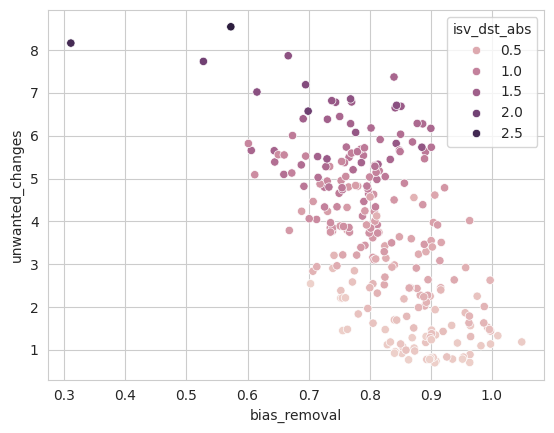

In [45]:
import seaborn as sns

sns.scatterplot(x='bias_removal', y='unwanted_changes', hue='isv_dst_abs', data=df)

In [32]:
np.argmax(df['bias_removal'])

27

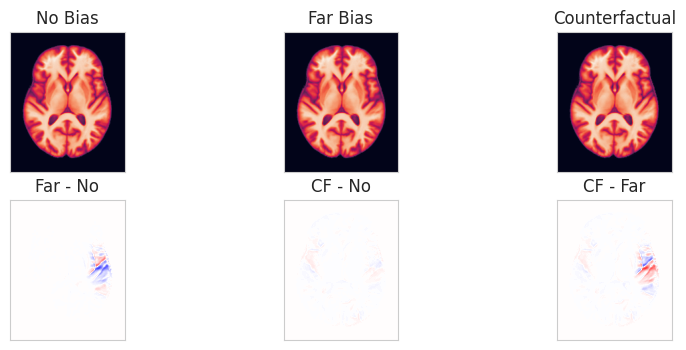

In [33]:
view_images(27)

<Axes: xlabel='subject_effect', ylabel='bias_effect'>

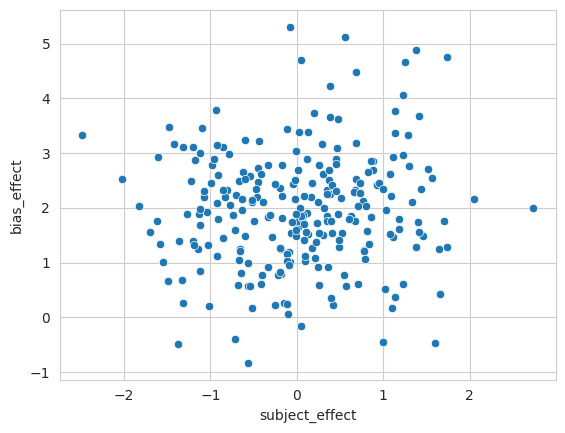

In [51]:
sns.scatterplot(x='subject_effect', y='bias_effect', data=df)

<Axes: xlabel='bias_effect', ylabel='disease_effect'>

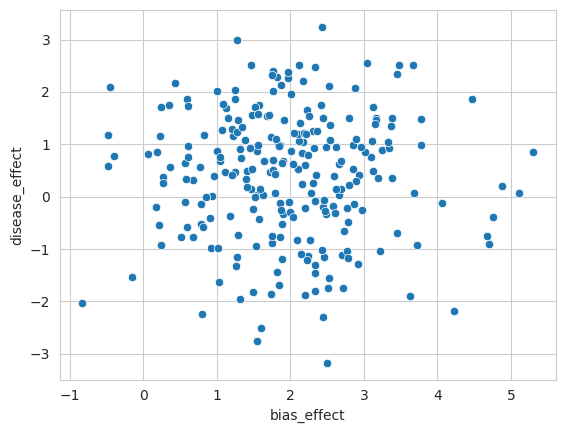

In [53]:
sns.scatterplot(x='bias_effect', y='disease_effect', data=df)